In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from operator import itemgetter

In [6]:
path = './'
Train_data = pd.read_csv(path + 'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path + 'used_car_testA_20200313.csv', sep=' ')
print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [4]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [5]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

**删除特征中的异常值**  
这里对nan数据是可以判断的！！！

In [11]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """
    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        # 判断标准：四分位距 * scale ！！！
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        # 异常值判断的下界： 下四分位距 - 判断标准
        val_low = data_ser.quantile(0.25) - iqr
        # 异常值判断的上界： 上四分位距 + 判断标准
        val_up = data_ser.quantile(0.75) + iqr
        # 下界过滤一次，生成bool索引
        rule_low = (data_ser < val_low)
        # 上界过滤一次，生成bool索引
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    
    # 删除条件取并集，满足任何一个异常值删除标准都 ok
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    # 根据 bool 索引找出被删除数据的 index
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("被删除的异常值数量为: {}".format(len(index)))
    # 根据 index 删除对应的数据
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("删除异常特征值后，数据总量为: {}".format(data_n.shape[0]), '\n')
    
    # data_series 未被改动，对异常值进行统计描述
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("对小于异常值下界的异常特征值进行统计描述:")
    print(pd.Series(outliers).describe(), '\n')
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("对大于异常值上界的异常特征值进行统计描述:")
    print(pd.Series(outliers).describe())
    
    # 绘制 某个特征 删除异常值前后的箱线图
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

被删除的异常值数量为: 963
删除异常特征值后，数据总量为: 149037 

对小于异常值下界的异常特征值进行统计描述:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64 

对大于异常值上界的异常特征值进行统计描述:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


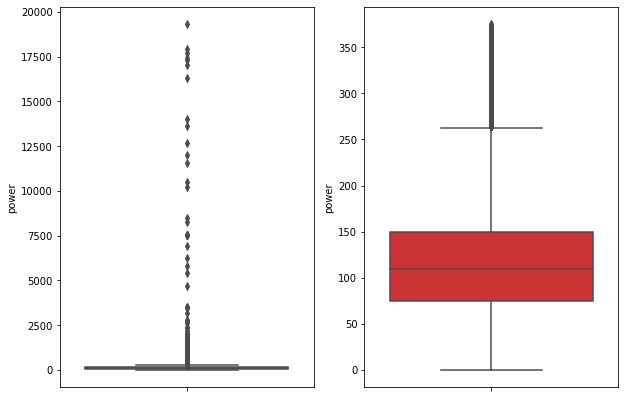

In [12]:
# 我们可以删掉一些异常数据，以 power 为例，但是删不删自行判断
# 但是要注意 test 的数据不能删(不能掩耳盗铃)！！！
Train_data = outliers_proc(Train_data, 'power', scale=3)

### 特征构造
#### 训练集和测试集放在一起，方便构造特征

In [59]:
Train_data['train'] = 1
Test_data['train'] = 0
# 默认 axis=0，测试集的 price特征为 nan
data = pd.concat([Train_data, Test_data], ignore_index=True)
print(data.shape) # (199037, 32)
data.head(3)

(199037, 32)


d:\softwares\anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,regDate,regionCode,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,20040402,1046,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,20030301,4366,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,20040403,2806,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075


#### 使用时间（天数）特征构造
反应汽车使用时间，一般来说价格与使用时间成反比，公式为：data['creatDate'] - data['regDate']

In [60]:
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [61]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
data['used_time'].isnull().sum()

15072

#### 从邮编中提取城市信息，相当于加入了先验知识

In [62]:
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data.city.isnull().sum()

0

#### 计算某品牌的销售统计量，还可以计算其他特征的统计量
针对训练集

In [63]:
Train_groups = Train_data.groupby("brand")
all_info = {}
# 对于每个商标种类和其对应的分组数据
for kind, kind_data in Train_groups:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    # Series 自带的不包括求均值，round 四舍五入保留两位小数
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info

In [75]:
pd.DataFrame(all_info)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
brand_amount,3.142900e+04,1.365600e+04,3.180000e+02,2.461000e+03,1.657500e+04,4.662000e+03,1.019300e+04,2.360000e+03,2.070000e+03,7.299000e+03,1.399400e+04,2.944000e+03,1.108000e+03,3.813000e+03,1.607300e+04,1.458000e+03,2.219000e+03,9.130000e+02,3.150000e+02,1.386000e+03,1.235000e+03,1.546000e+03,1.085000e+03,183.00000,6.300000e+02,2.059000e+03,8.780000e+02,2.049000e+03,6.330000e+02,4.060000e+02,9.400000e+02,318.000000,5.880000e+02,2.010000e+02,227.000000,180.000000,228.000000,3.310000e+02,65.000000,9.000000
brand_price_max,6.850000e+04,8.400000e+04,5.580000e+04,3.750000e+04,9.999900e+04,3.150000e+04,3.599000e+04,3.890000e+04,9.999900e+04,6.853000e+04,9.290000e+04,3.450000e+04,2.749000e+04,3.500000e+04,3.899000e+04,4.500000e+04,1.790000e+04,5.580000e+04,3.459900e+04,4.235000e+04,3.780000e+04,3.599900e+04,4.390000e+04,64000.00000,9.999900e+04,2.250000e+04,9.999900e+04,6.290000e+04,3.990000e+04,1.999000e+04,2.320000e+04,11000.000000,3.350000e+04,6.500000e+04,2900.000000,28900.000000,20900.000000,8.650000e+04,8999.000000,14500.000000
brand_price_median,3.199000e+03,6.399000e+03,7.500000e+03,4.990000e+03,5.999000e+03,2.300000e+03,1.800000e+03,2.600000e+03,2.270000e+03,1.400000e+03,5.200000e+03,2.900000e+03,2.625000e+03,1.600000e+03,1.700000e+03,8.500000e+03,2.999000e+03,2.200000e+03,1.999000e+03,2.800000e+03,1.750000e+03,4.225000e+03,3.950000e+03,1200.00000,2.745000e+04,2.500000e+03,5.000000e+03,4.200000e+03,3.790000e+03,5.250000e+03,3.295000e+03,1000.000000,2.350000e+03,5.600000e+03,999.000000,950.000000,2250.000000,1.325000e+04,2850.000000,1900.000000
brand_price_min,1.300000e+01,1.500000e+01,3.500000e+01,6.500000e+01,1.200000e+01,2.000000e+01,1.300000e+01,6.000000e+01,3.000000e+01,5.000000e+01,1.500000e+01,3.000000e+01,5.000000e+01,2.000000e+01,1.200000e+01,1.000000e+02,2.000000e+01,1.500000e+01,5.000000e+01,2.000000e+01,1.500000e+01,5.000000e+01,5.000000e+01,99.00000,1.500000e+01,2.500000e+01,1.100000e+01,3.500000e+01,8.000000e+01,5.000000e+02,5.000000e+01,50.000000,5.000000e+01,9.800000e+02,60.000000,50.000000,150.000000,5.500000e+02,99.000000,750.000000
brand_price_sum,1.737197e+08,1.240446e+08,3.766241e+06,1.595423e+07,1.382791e+08,1.541432e+07,3.645752e+07,9.905909e+06,1.001717e+07,1.780527e+07,1.130342e+08,1.339801e+07,4.494303e+06,1.067579e+07,4.907665e+07,1.437381e+07,8.078352e+06,3.328679e+06,1.519049e+06,7.228288e+06,4.292737e+06,8.856481e+06,6.543426e+06,597132.00000,2.042278e+07,7.515546e+06,7.242792e+06,1.086256e+07,3.373957e+06,2.459028e+06,3.939145e+06,560155.000000,2.360095e+06,1.839801e+06,231776.000000,297977.000000,816001.000000,5.371844e+06,215620.000000,39480.000000
brand_price_std,6.261372e+03,8.988865e+03,1.057622e+04,5.396328e+03,8.089863e+03,3.344690e+03,4.562233e+03,4.752584e+03,6.053233e+03,2.975343e+03,8.244695e+03,4.722160e+03,4.066960e+03,3.073915e+03,3.605595e+03,5.425058e+03,2.450906e+03,3.952913e+03,6.358410e+03,6.186539e+03,4.400530e+03,5.257235e+03,5.877141e+03,7333.69514,1.985550e+04,3.556250e+03,1.028299e+04,4.853289e+03,4.509036e+03,3.639738e+03,3.659577e+03,1829.079211,4.394596e+03,9.637135e+03,554.118445,3325.933365,3922.715389,1.354118e+04,2140.083145,5520.867233
brand_price_average,5.527190e+03,9.082860e+03,1.180640e+04,6.480190e+03,8.342130e+03,3.305670e+03,3.576370e+03,4.195640e+03,4.836880e+03,2.439080e+03,8.076760e+03,4.549410e+03,4.052570e+03,2.799110e+03,3.053170e+03,9.851830e+03,3.638900e+03,3.641880e+03,4.807120e+03,5.211450e+03,3.473090e+03,5.724940e+03,6.025250e+03,3245.28000,3.236573e+04,3.648320e+03,8.239810e+03,5.298810e+03,5.321700e+03,6.041840e+03,4.186130e+03,1755.970000,4.006950e+03,9.107930e+03,1016.560000,1646.280000,3563.320000,1.618025e+04,3266.970000,3948.000000


In [65]:
# df 的数据转置
brand_stats = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
# 基于 brand 特征（on='brand')将 brand_stats 的数据合并到 data（how='left'）
data = data.merge(brand_stats, how='left', on='brand')
data[:10]

,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,regDate,regionCode,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,20040402,1046,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,4385.0,1,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,20030301,4366,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,4757.0,4,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,20040403,2806,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,4382.0,2,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,0,193,2400.0,19960908,434,0,1,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,7125.0,,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,0,68,5200.0,20120103,6977,0,1,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,1531.0,6,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67
5,5,0.0,10,20160319,1.0,0.0,10.0,24.0,137642,0.0,0,109,8000.0,20090602,3690,0,1,46.323165,-3.229285,1.885526,-2.721943,2.457660,-0.286973,0.206573,0.156615,-1.727217,-0.345690,0.260246,0.000518,0.119838,0.090922,0.048769,2482.0,3,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76
6,6,0.0,4,20160317,0.0,1.0,15.0,13.0,2402,0.0,0,150,3500.0,19990411,3073,0,1,46.104335,4.926219,-4.902200,1.610616,-0.834605,-1.996117,-0.103180,0.113311,1.644606,-1.270381,0.267998,0.117675,0.142334,0.025446,0.028174,6185.0,3,16575.0,99999.0,5999.0,12.0,138279069.0,8089.863295,8342.13
7,7,1.0,14,20160326,0.0,0.0,15.0,26.0,165346,0.0,0,101,1000.0,19990706,4000,0,1,42.255586,-3.167771,3.693829,-0.245014,-2.192810,0.236728,0.195567,-0.676693,1.942673,0.524206,0.239506,0.000000,0.122943,0.039839,0.082413,6108.0,4,16073.0,38990.0,1700.0,12.0,49076652.0,3605.595127,3053.17
8,8,2.0,1,20160326,1.0,1.0,15.0,19.0,2974,0.0,0,179,2850.0,20030205,4679,0,1,46.084888,4.893717,-4.925234,1.587796,0.075348,-1.551098,0.069433,0.475333,0.556575,-1.262490,0.263833,0.116583,0.144255,0.039851,0.024388,4798.0,4,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86
9,9,5.0,7,20160402,0.0,0.0,15.0,7.0,82021,0.0,0,88,650.0,19980101,302,0,1,43.074626,1.666386,-1.089584,0.600683,-4.186210,0.198273,-1.025822,-2.201545,3.096861,0.843852,0.262473,0.068267,0.012176,0.010291,0.098727,6666.0,,2360.0,38900.0,2600.0,60.0,9905909.0,4752.584154,4195.64


In [66]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多：
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，**每个变量有单独的权重**，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行**特征交叉**，提升表达能力，由 M+N 个变量变成 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化
# 6. 增强模型的泛化性能，如：LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性
# 当然还有很多原因，

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head(3).append(data[['power_bin', 'power']].tail(3))

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
199034,22.0,224
199035,NaN,334
199036,6.0,68


In [67]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [68]:
data.shape

(199037, 39)

In [69]:
data.columns

Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

#### 将给树模型使用的特征数据压缩保存
相比于csv格式，会剩一半内存,index???

In [70]:
data.to_csv('data_for_tree.gz', index=0)

In [3]:
# 再读取保存的数据
data = pd.read_csv('data_for_tree.gz')
data[:5]

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,0,1,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,4385.0,1.0,10193.0,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.37,5.0
1,1,2.0,1,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,0,1,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,4757.0,4.0,13656.0,84000.0,6399.0,15.0,124044603.0,8988.865406,9082.86,NaN
2,2,1.0,15,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,0,1,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,4382.0,2.0,1458.0,45000.0,8500.0,100.0,14373814.0,5425.058140,9851.83,16.0
3,3,0.0,10,0.0,1.0,15.0,109.0,71865,0.0,0,193,2400.0,0,1,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,7125.0,NaN,13994.0,92900.0,5200.0,15.0,113034210.0,8244.695287,8076.76,19.0
4,4,1.0,5,0.0,0.0,5.0,110.0,111080,0.0,0,68,5200.0,0,1,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,1531.0,6.0,4662.0,31500.0,2300.0,20.0,15414322.0,3344.689763,3305.67,6.0


#### 再构造一份特征给 LR NN 之类的模型用
之所以分开构造是因为，不同模型对数据集的要求不同

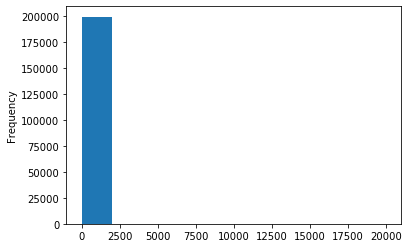

In [4]:
# 我们看下数据分布：
data['power'].plot.hist()  # 而不是distplot绘制

前面已经对 train 进行异常值处理了，现在还有这么奇怪的分布的原因是 test 中的 power 异常值没被处理。所以刚刚 train 中的 power 异常值还是不删为好，可以用**长尾分布截断**来代替

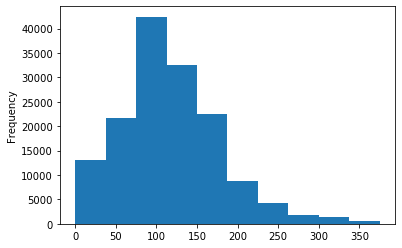

In [13]:
Train_data['power'].plot.hist()  # 不能直接加载Train_data，需要进行异常值处理

In [14]:
np.min(data['power']) # 标量被广播

0

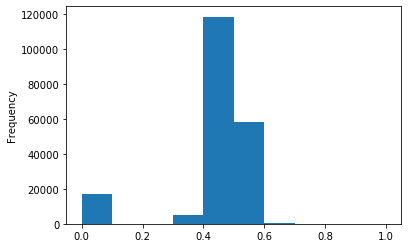

In [15]:
# 我们对其取 log（？？），再做归一化，就不保留原始的 power 特征了

data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

仍是Series，必须加.values转换为 numpy后才有 reshape方法

In [21]:
np.log(data['power'] + 1)

0         4.110874
1         0.000000
2         5.099866
3         5.267858
4         4.234107
            ...   
199032    4.762174
199033    4.330733
199034    5.416100
199035    5.814131
199036    4.234107
Name: power, Length: 199037, dtype: float64

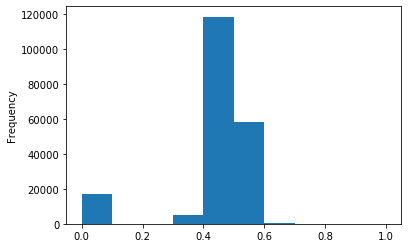

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fit 或者 transform的数据必须是二维的，单独的一个特征列或元素需要reshape为(-1,1)或(1，)
scaler.fit( np.log(data['power'] + 1).values.reshape(-1,1))
# Exception: Data must be 1-dimensional
pd.Series( scaler.transform( np.log(data['power'] + 1).values.reshape(-1,1) ).reshape(-1,) ).plot.hist()

kilometer 特征的分布比较正常，应该是已经做过分桶了

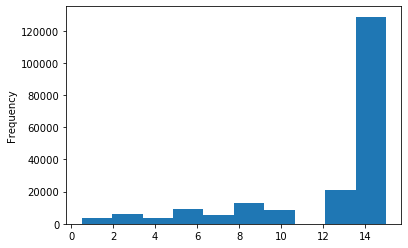

In [23]:
data['kilometer'].plot.hist()

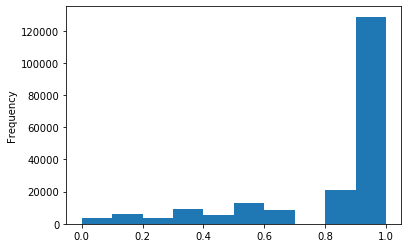

In [24]:
# 所以我们可以直接做归一化，分布图的形状没变化
data['kilometer'] = (   (data['kilometer'] - np.min(data['kilometer']) ) / 
                        ( np.max(data['kilometer']) - np.min(data['kilometer']))    )
data['kilometer'].plot.hist()

In [34]:
# 除此之外 还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max', 'brand_price_median', 
# 'brand_price_min', 'brand_price_std', 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换

# series的map ，DataFrame中对应的是applymap()函数，当然DataFrame还有apply()函数 元素级函数
def max_min_Normalization(x):
    """minmax归一化，极差变换，直接作用于series，而不是series的元素"""
    return (x - np.min(x)) / (np.max(x) - np.min(x))

stats_cols = ['brand_amount', 'brand_price_average', 'brand_price_max', 'brand_price_median', 
              'brand_price_min', 'brand_price_std', 'brand_price_sum']
for col in stats_cols:
    data[col] = max_min_Normalization(data[col])

对类别特征进行 OneEncoder （独热码？）

In [37]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [44]:
print(data.shape)

(199037, 370)


In [45]:
data.columns

Index(['SaleID', 'kilometer', 'name', 'offerType', 'power', 'price', 'seller',
       'train', 'v_0', 'v_1',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

In [46]:
data.iloc[1:3]

,SaleID,kilometer,name,offerType,power,price,seller,train,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,model_0.0,model_1.0,model_2.0,model_3.0,model_4.0,model_5.0,model_6.0,model_7.0,model_8.0,model_9.0,model_10.0,model_11.0,model_12.0,model_13.0,model_14.0,model_15.0,model_16.0,model_17.0,model_18.0,model_19.0,model_20.0,model_21.0,model_22.0,model_23.0,model_24.0,model_25.0,model_26.0,model_27.0,model_28.0,model_29.0,model_30.0,model_31.0,model_32.0,model_33.0,model_34.0,model_35.0,model_36.0,model_37.0,model_38.0,model_39.0,model_40.0,model_41.0,model_42.0,model_43.0,model_44.0,model_45.0,model_46.0,model_47.0,model_48.0,model_49.0,model_50.0,model_51.0,model_52.0,model_53.0,model_54.0,model_55.0,model_56.0,model_57.0,model_58.0,model_59.0,model_60.0,model_61.0,model_62.0,model_63.0,model_64.0,model_65.0,model_66.0,model_67.0,model_68.0,model_69.0,model_70.0,model_71.0,model_72.0,model_73.0,model_74.0,model_75.0,model_76.0,model_77.0,model_78.0,model_79.0,model_80.0,model_81.0,model_82.0,model_83.0,model_84.0,model_85.0,model_86.0,model_87.0,model_88.0,model_89.0,model_90.0,model_91.0,model_92.0,model_93.0,model_94.0,model_95.0,model_96.0,model_97.0,model_98.0,model_99.0,model_100.0,model_101.0,model_102.0,model_103.0,model_104.0,model_105.0,model_106.0,model_107.0,model_108.0,model_109.0,model_110.0,model_111.0,model_112.0,model_113.0,model_114.0,model_115.0,model_116.0,model_117.0,model_118.0,model_119.0,model_120.0,model_121.0,model_122.0,model_123.0,model_124.0,model_125.0,model_126.0,model_127.0,model_128.0,model_129.0,model_130.0,model_131.0,model_132.0,model_133.0,model_134.0,model_135.0,model_136.0,model_137.0,model_138.0,model_139.0,model_140.0,model_141.0,model_142.0,model_143.0,model_144.0,model_145.0,model_146.0,model_147.0,model_148.0,model_149.0,model_150.0,model_151.0,model_152.0,model_153.0,model_154.0,model_155.0,model_156.0,model_157.0,model_158.0,model_159.0,model_160.0,model_161.0,model_162.0,model_163.0,model_164.0,model_165.0,model_166.0,model_167.0,model_168.0,model_169.0,model_170.0,model_171.0,model_172.0,model_173.0,model_174.0,model_175.0,model_176.0,model_177.0,model_178.0,model_179.0,model_180.0,model_181.0,model_182.0,model_183.0,model_184.0,model_185.0,model_186.0,model_187.0,model_188.0,model_189.0,model_190.0,model_191.0,model_192.0,model_193.0,model_194.0,model_195.0,model_196.0,model_197.0,model_198.0,model_199.0,model_200.0,model_201.0,model_202.0,model_203.0,model_204.0,model_205.0,model_206.0,model_207.0,model_208.0,model_209.0,model_210.0,model_211.0,model_212.0,model_213.0,model_214.0,model_215.0,model_216.0,model_217.0,model_218.0,model_219.0,model_220.0,model_221.0,model_222.0,model_223.0,model_224.0,model_225.0,model_226.0,model_227.0,model_228.0,model_229.0,model_230.0,model_231.0,model_232.0,model_233.0,model_234.0,model_235.0,model_236.0,model_237.0,model_238.0,model_239.0,model_240.0,model_241.0,model_242.0,model_243.0,model_244.0,model_245.0,model_246.0,model_247.0,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11,brand_12,brand_13,brand_14,brand_15,brand_16,brand_17,brand_18,brand_19,brand_20,brand_21,brand_22,brand_23,brand_24,brand_25,brand_26,brand_27,brand_28,brand_29,brand_30,brand_31,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,bodyType_0.0,bodyType_1.0,bodyType_2.0,bodyType_3.0,bodyType_4.0,bodyType_5.0,bodyType_6.0,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-,notRepairedDamage_0.0,notRepairedDamage_1.0,power_bin_0.0,power_bin_1.0,power_bin_2.0,power_bin_3.0,power_bin_4.0,power_bin_5.0,power_bin_6.0,power_bin_7.0,power_bin_8.0,power_bin_9.0,power_bin_10.0,power_bin_11.0,power_bin_12.0,power_bin_13.0,power_bin_14.0,power_bin_15.0,power_bin_16.0,po

In [42]:
for col in stats_cols:
    data.drop(axis=1, columns=[col + '_2'], inplace=True)
    data.drop(axis=1, columns=[col + '_1'], inplace=True)

或者一次删除多个特征

In [52]:
stats_cols1 = [col + '_1' for col in stats_cols]
stats_cols2 = [col + '_2' for col in stats_cols]
print(stats_cols1)
print(stats_cols2)

['brand_amount_1', 'brand_price_average_1', 'brand_price_max_1', 'brand_price_median_1', 'brand_price_min_1', 'brand_price_std_1', 'brand_price_sum_1']
['brand_amount_2', 'brand_price_average_2', 'brand_price_max_2', 'brand_price_median_2', 'brand_price_min_2', 'brand_price_std_2', 'brand_price_sum_2']


In [ ]:
data.drop(columns=stats_cols1, axis=1, inplace=True)

In [ ]:
del data['power_log']

In [47]:
data.to_csv('data_for_lr.gz', index=0)

加载数据

In [2]:
data = pd.read_csv('data_for_lr.gz')
data.shape

(199037, 370)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199037 entries, 0 to 199036
Columns: 370 entries, SaleID to power_bin_29.0
dtypes: float64(26), int64(344)
memory usage: 561.9 MB


In [4]:
import sys
sys.getsizeof(data) / 1024 / 1024

561.8569107055664

尝试着压缩每个特征所占的内存后，再压缩保存

In [7]:
def reduce_mem_usage(df):
    """ iterate df 的每个特征，修改数据类型，降低内存占用 """
    # 初始 df 的内存占用, sum的结果是 B，除以两个1024，变成 MB
    start_mem = df.memory_usage().sum() / 1024 / 1024 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # 对于非object的数值型特征，分别计算该特征的最小值和最大值所占内存的上下界
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # 如果是整型数据，从占用内存最小的数据类型开始，依次进行数值比较，测试 特征的取值范围 是否在 该数据类型的取值范围里
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            # 如果是浮点型数据，同样是依次进行比较，但是最小的是float16，而且float32基本上已经足够大，够用了
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # 对于object型数据，转换为分类型数据，降低内存占用(没有时间型特征，只留了使用天数)
        else:
            df[col] = df[col].astype('category')
    
    # 修改每个特征的数据类型后，df 的内存占用
    end_mem = df.memory_usage().sum()  / 1024 / 1024 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
# 大概需要1分钟左右
data = reduce_mem_usage(data)

Memory usage of dataframe is 561.86 MB
Memory usage after optimization is: 76.88 MB
Decreased by 86.3%


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199037 entries, 0 to 199036
Columns: 370 entries, SaleID to power_bin_29.0
dtypes: float16(25), float32(1), int16(1), int32(2), int8(341)
memory usage: 76.9 MB


压缩特征后保存，文件大小从37MB——15MB

In [9]:
# 这个保存需要的时间也 1 min左右，默认单核cpu
data.to_csv('data_for_lr1.gz', index=0)

#### 新的数据加载
部分特征和预测目标仍存在缺失值

In [20]:
data = pd.read_csv('data_for_lr1.gz')
data.shape

(199037, 370)

In [21]:
data.columns[data.isnull().any()]

Index(['price', 'used_time', 'city'], dtype='object')

### 特征筛选

#### 过滤式
单个变量之间的相关性分析

In [10]:
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.27074629358930297
0.38691042393409447


对应的热力图

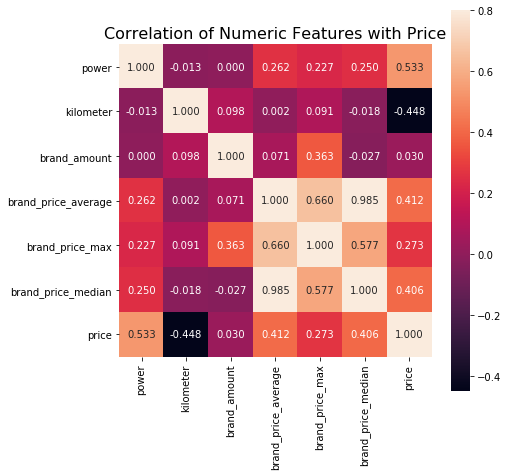

In [11]:
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 
                     'brand_price_max', 'brand_price_median', 'price']]
correlation = data_numeric.corr()

# plt 设置画板，sns 作图
f, ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price', y=1, size=16)
sns.heatmap(correlation, square = True, vmax=0.8, annot=True, fmt='.3f')

#### 包裹式
**数据仍有缺失值，无法做包裹式特征筛选，用0填充**

In [15]:
# data.isnull().any()结果是series，无法用df索引，长度不对
data.columns[data.isnull().any()]

Index(['price', 'used_time', 'city'], dtype='object')

In [16]:
data = data.fillna(0)
data.columns[data.isnull().any()]

Index([], dtype='object')

原来的方法只是填充了特征中的缺失值，但是没有填充预测目标的缺失值，所以报错

In [17]:
# k_feature 太大会很难跑，在本电脑上，单核cpu：2-3分钟
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=10,   # 选择10个特征
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
# 去除预测目标和填充缺失值，并未改变 data 数据
x = data.drop(['price'], axis=1)  
# x = x.fillna(0)
y = data['price']
sfs.fit(x, y)
sfs.k_feature_names_ 

('kilometer',
 'train',
 'v_0',
 'v_3',
 'v_7',
 'used_time',
 'brand_price_std',
 'brand_price_average',
 'model_167.0',
 'gearbox_1.0')

d:\softwares\anaconda\envs\tf\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
d:\softwares\anaconda\envs\tf\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


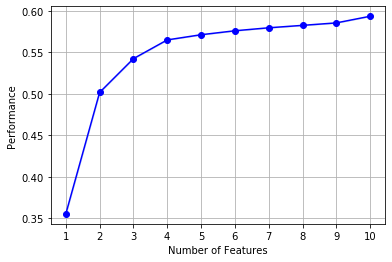

In [18]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

#### 嵌入式

In [ ]:
# 下一章介绍，Lasso 回归和决策树可以完成嵌入式特征选择